# Oil Spill Detection Use Case Example on Test Image 3

In [2]:
import asf_search as asf
import getpass
from os import listdir
import pyroSAR
from pyroSAR.snap.auxil import parse_recipe, parse_node, gpt, groupbyWorkers
from pyroSAR.S1 import OSV
from pyroSAR import identify
import tensorflow as tf
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.enums import Resampling
from matplotlib import pyplot as plt
import numpy as np
import json
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import transform
import folium
from folium import plugins
from folium import IFrame
from folium.raster_layers import ImageOverlay
import geopandas as gpd
import pyproj
import keras
from patchify import patchify, unpatchify
from skimage import io, exposure, data
import cv2
import time as t

# Download Sentinel-1 image from Alaska Satellite Facility (ASF)

In [5]:
session = asf.ASFSession()

username = input('Username:')
password = getpass.getpass('Password:')

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Username:mohammedkhalid056@gmail.com
Password:········
Success!


In [20]:
directory = r'./'

granule = 'S1A_IW_GRDH_1SDV_20220217T141650_20220217T141715_041954_04FEFA_F651'

result = asf.granule_search(granule)
# print(result)

result.download(path=directory, session=user_pass_session)

# listdir(directory)

# Preprocess the Sentinel-1 image using SNAP API

In [21]:
workflow = parse_recipe('blank')

read = parse_node('Read')
read.parameters['file'] = './S1A_IW_GRDH_1SDV_20220217T141650_20220217T141715_041954_04FEFA_F651.zip'
read.parameters['formatName'] = 'SENTINEL-1'
workflow.insert_node(read)

orb = parse_node('Apply-Orbit-File')
orb.parameters['orbitType'] = 'Sentinel Precise (Auto Download)'
orb.parameters['continueOnFail'] = True
workflow.insert_node(orb, before=read.id)

# sbs = parse_node('Subset')
# sbs.parameters['copyMetadata'] = True
# sbs.parameters['sourceBands'] = ['VV']
# workflow.insert_node(sbs, before=orb.id)

tnr = parse_node('ThermalNoiseRemoval')
tnr.parameters['removeThermalNoise'] = 'true'
workflow.insert_node(tnr, before=orb.id)

bnr = parse_node('Remove-GRD-Border-Noise')
bnr.parameters['selectedPolarisations'] = ['VV']
workflow.insert_node(bnr, before=tnr.id)

lnd = parse_node('Land-Sea-Mask')
lnd.parameters['landMask'] = 'true'
workflow.insert_node(lnd, before=bnr.id)

cal = parse_node('Calibration')
cal.parameters['outputSigmaBand'] = 'true'
cal.parameters['sourceBands'] = 'Intensity_VV'
cal.parameters['selectedPolarisations'] = 'VH,VV'
cal.parameters['outputImageScaleInDb'] = 'false'
workflow.insert_node(cal, before=lnd.id)

spk = parse_node('Speckle-Filter')
spk.parameters['filter'] = 'Lee Sigma'
spk.parameters['filterSizeX'] = '3'
spk.parameters['filterSizeY'] = '3'
workflow.insert_node(spk, before=cal.id)

db = parse_node('LinearToFromdB')
db.parameters['sourceBands'] = 'Sigma0_VV'
workflow.insert_node(db, before=spk.id)

und = parse_node('Undersample')
und.parameters['method'] = 'LowPass Filtering'
und.parameters['outputImageBy'] = 'Pixel Spacing'
und.parameters['filterSize'] = '3x3'
und.parameters['rangeSpacing'] = '80'
und.parameters['azimuthSpacing'] = '80'
workflow.insert_node(und, before=db.id)

prj = parse_node('Ellipsoid-Correction-GG')
prj.parameters['mapProjection'] = 'WGS84(DD)'
workflow.insert_node(prj, before=und.id)

write = parse_node('Write')
write.parameters['file'] = '20220217T141650_preprocessed'
write.parameters['formatName'] = 'GeoTIFF'
workflow.insert_node(write, before=prj.id)

workflow.write('20220217T141650_preprocessed')

In [22]:
start = t.time()

gpt(xmlfile = '20220217T141650_preprocessed.xml', outdir='./', groups=groupbyWorkers('20220217T141650_preprocessed.xml', n=1))

end = t.time()
time_taken = (end - start)/60
print(f'time taken: {time_taken} min')

executing node sequences..
Apply-Orbit-File
ThermalNoiseRemoval
Remove-GRD-Border-Noise
Land-Sea-Mask
Calibration
Speckle-Filter
LinearToFromdB
Undersample
Ellipsoid-Correction-GG
done
time taken: 11.975548565387726 min


# Prepare the data for deep learning model inference

In [15]:
def load_geotiff_image(file_path):
    """
    A function that uses the rasterio library to read a GeoTIFF image and convert it into a numpy array
    """
    
    with rasterio.open(file_path) as dataset:

        data = dataset.read()

    #rearrage the order of the image channel from first to last
    image = np.moveaxis(data, 0, -1)
    return image

def normalise(input_image):
    n_image = (input_image - input_image.min()) / (input_image.max()- input_image.min())
    return n_image

def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.uint8), mask=(mask >0), connectivity=8, transform=transform):
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    
    return all_polygons

def pad_image(image):
    # Determine patch size and number of patches needed in each dimension
    rows, cols, _ = image.shape
    num_rows = rows // 512
    num_cols = cols // 512
    
    # Calculate padding needed
    pad_rows = 512 - (rows % 512)
    pad_cols = 512 - (cols % 512)
    
    # ad the original image with the calculated padding
    image_padded = np.pad(image, ((0, pad_rows), (0, pad_cols), (0, 0)), mode='constant')
    return image_padded

def unpad_image(image_padded, original_shape):
    """
    Unpad a padded image back to its original size.

    Args:
        image_padded (numpy.ndarray): Padded image.
        original_image: Original image with shape (height, width, channels).

    Returns:
        numpy.ndarray: Unpadded image.
    """
    # Extract original shape
    original_rows = original_shape[:,:,0].shape[0]
    original_cols = original_shape[:,:,0].shape[1]
    
    # Slice the padded image to the original shape
    image_unpadded = image_padded[:original_rows, :original_cols]
    
    return image_unpadded

def remove_small_regions(mask, min_size):
    # Perform morphological opening on the mask using a rectangular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Find all connected components in the opened mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask, connectivity=8)

    # Remove small regions by setting them to background
    cleaned_mask = np.zeros_like(mask)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size:
            cleaned_mask[labels == label] = 1

    return cleaned_mask

In [10]:
unpadded_large_image = load_geotiff_image('./20220217T141650_preprocessed.tif')

unpadded_large_image = np.array(unpadded_large_image)
unpadded_large_image[np.isnan(unpadded_large_image)] = 0

print("Before padding:", unpadded_large_image.shape)
padded_large_image = pad_image(unpadded_large_image)
print("After padding:", padded_large_image.shape)

Before padding: (2682, 3949, 1)
After padding: (3072, 4096, 1)


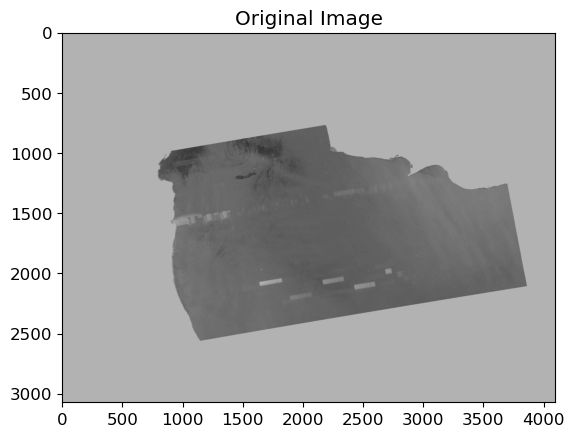

In [11]:
plt.title("Original Image")
plt.imshow(padded_large_image[:, :, 0], cmap='gray')
plt.show()

# Pass the image into the model

In [12]:
unet = keras.models.load_model('/home/users/b90068501/diss/unet_200epc_aug_best_20230330.h5', compile=False)
deeplab = keras.models.load_model('/home/users/b90068501/diss/deeplabv3_200epc_aug_best_20230330.h5', compile=False)

In [13]:
size_x = (padded_large_image.shape[0]//512)*512
size_y = (padded_large_image.shape[1]//512)*512
padded_large_image = np.array(padded_large_image)
padded_large_image = padded_large_image[0:size_x,0:size_y]
patches_img = patchify(padded_large_image, (512,512,1), step=512)
patches_img = patches_img[:,:,0,:,:,:]
print(patches_img.shape)

(6, 8, 512, 512, 1)


/tmp/ipykernel_34161/2748140099.py:15: RuntimeWarning: invalid value encountered in divide
  n_image = (input_image - input_image.min()) / (input_image.max()- input_image.min())


time taken: 0.11886638402938843 min


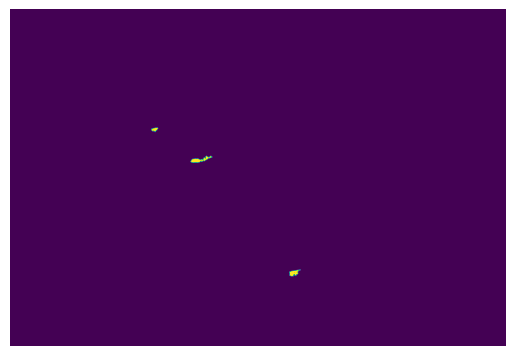

In [16]:
start = t.time()

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i,j,:,:,:]
        # Create a masked array where values greater than 0 are masked
        masked_array = np.ma.masked_greater(single_patch_img, -10)
        # Calculate median of the unmasked values
        single_patch_img[(single_patch_img >= -10)] = np.ma.median(masked_array)
        single_patch_img = normalise(single_patch_img)
        single_patch_img = tf.convert_to_tensor(single_patch_img)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        single_patch_img = np.expand_dims(single_patch_img, axis=-1)
        unet_patchify_pred = unet.predict(single_patch_img, verbose=0)
        deeplab_patchify_pred = deeplab.predict(single_patch_img, verbose=0)
        weighted_patchify_pred = np.tensordot(np.array([deeplab_patchify_pred, unet_patchify_pred]), [0.6, 0.4], axes=((0),(0)))
        weighted_patchify_pred_t = (weighted_patchify_pred > 0.5).astype(np.uint8)
        weighted_patchify_pred_t = np.squeeze(weighted_patchify_pred_t)
        weighted_patchify_pred_t = remove_small_regions(weighted_patchify_pred_t, 900)
        patched_prediction.append(weighted_patchify_pred_t)


patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (padded_large_image.shape[0], padded_large_image.shape[1]))
unpadded_prediction = unpad_image(unpatched_prediction, unpadded_large_image)

end = t.time()
time_taken = (end - start)/60
print(f'time taken: {time_taken} min')

plt.imshow(unpadded_prediction)
plt.axis('off')
plt.show()

# Copy coordinate system information and transformation parameters from original image

In [17]:
#Copy metadata from original GeoTIFF file
with rasterio.open("./20220217T141650_preprocessed.tif") as dataset:
    
    img = dataset.read()
 
    # Get a copy of the source dataset's profile. Thus our
    # destination dataset will have the same georeferencing as the
    # source dataset.
    transform = dataset.transform
    extent = dataset.bounds
    left, bottom, right, top = extent
    kwds = dataset.profile

    print(kwds)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3949, 'height': 2682, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0007186522272956172, 0.0, 55.69757410086729,
       0.0, -0.0007186522272956172, 26.495346820195262), 'tiled': False, 'interleave': 'band'}


# Save the oilspill prediction polygon as a Geopackage or Shapefile

In [18]:
polys = mask_to_polygons_layer(unpadded_prediction)

polys_gdf = gpd.GeoDataFrame({'id': [1],
                        'name': ['oil spill']}, geometry=[polys])
polys_gdf = polys_gdf.set_crs(epsg=4326)

polys_gdf.to_file('oilspills.gpkg', driver='GPKG', layer='test_image_3_oilspill')  

# Plot the model's predictions on a map

In [23]:
#Find the centroid to position the map
centroidp = MultiPolygon(polys).centroid

long = centroidp.x
lat = centroidp.y

#Convert oil spill extent polygon to GeoJSON
polys_geojson = polys_gdf.to_json()

# Create folium map
mymap = folium.Map(location=[lat, long], tiles='CartoDB positron', zoom_start=9, control_scale = True)
# Convert the GeoTIFF image data to an image overlay

# Convert polys to GeoJson and add to map
plotpoly =folium.features.GeoJson(polys_geojson)

mymap.add_child(plotpoly)

# Define the legend HTML
legend_html = """
<div style="
    position: fixed;
    Top: 20px;
    right: 20px;
    background-color: white;
    z-index: 1000;
    padding: 10px;
    border: 1px solid gray;
">
    <div style="margin-bottom: 5px;">
        <strong>Legend</strong>
    </div>
    <div>
        <span style="display: inline-block; width: 20px; height: 10px; background-color: lightblue; border: 1px solid blue;"></span>
        <span style="margin-left: 5px;">Oil Spill</span>
    </div>
</div>
"""

# Add the legend HTML as an HTML overlay to the map
mymap.get_root().html.add_child(folium.Element(legend_html))

display(mymap)